<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE60499](https://ndcbe.github.io/CBE60499);
content is available [on Github](git@github.com:ndcbe/CBE60499.git).*


<!--NAVIGATION-->
< [2.4 Dynamic Optimization: Differential Algebraic Equations (DAEs)](https://ndcbe.github.io/CBE60499/02.04-DAE-modeling.html) | [Contents](toc.html) | [2.5 Quadrature Rules](https://ndcbe.github.io/CBE60499/02.05-Quadrature-Rules.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/02.05-Numeric-Integration.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/02.05-Numeric-Integration.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 2.5 Runge Kutta: Single-Step Numeric Integration
**Lecture 19**. CBE 60499. Fall 2018. A. Dowling.

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

## 2.5.1 General Form: Index 0 DAE

Consider the ODE system:
$$\begin{equation*}
\dot{z} = f(t,z), \quad z(t_0) = z_0
\end{equation*}$$

where $z(t)$ are the differentail variables and $f(t,z)$ is a (nonlinear) continous function.

The general Runge-Kutta formula is:
$$\begin{align*}
z_{i+1} &= z_{i} + h_i \sum_{k=1}^{n_s} b_k f(t_i + c_k h_i, \hat{z}_k) \\
    \hat{z}_k &= z_i + h_i \sum_{j=1}^{n_{rk}} a_{k,j} f(t_i + c_j h_i, \hat{z}_j), \quad k=1,...,n_s 
\end{align*}$$

where
* $z_i$ are the differential variables at the **start** of **step** $i$ (time $t_i$)
* $z_{i+1}$ are the differential variables at the **end** of **step** $i$ (time $t_{i+1}$)
* $\hat{z}_k$ are differential variables for **intermediate stage** $k$
* $h_i$ is the size for step $i$ such that $t_{i+1} = t_i + h_i$
* $n_s$ is the number of stages
* $n_{rk}$ is the number of $f(\cdot)$ evaluations to calculate intermediate $k$
* $a_{k,j}$ are coefficients, together known as the *Runge-Kutta matrix*
* $b_k$ are cofficients, known as the *weights*
* $c_k$ are coefficients, know as the *nodes*

$h_i$ is selected based on error tolerances

The choice for $A$, $b$ and $c$ selects the specific method in the *Runge-Kutta family*. These coefficients are often specific in a [Buther block](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#Explicit_Runge).

A Runge-Kutta method is called [**consistent**](https://en.wikiversity.org/wiki/Numerical_Analysis/stability_of_RK_methods) if:
$$\begin{equation*}
\sum_{k=1}^{n_s} b_k = 1 \quad \mathrm{and} \quad \sum_{j=1}^{n_s} a_{k,j} = c_k
\end{equation*}$$

## 2.5.2 Explicit (Forward) Euler

Consider one of the simplest Runge-Kutta methods:

$$z_{i+1} = z_{i} + h_i~f(t_i, z_i)$$

What are $A$, $b$ and $c$ in the general formula?

$n_s = 1$. This is only a single stage. Thus we only need to determine $c_1$, $b_1$, and $n_{r1}$

Moreover, $\hat{z}_1 = z_i$ because $f(\cdot)$ is only evaluated at $t_i$ and $z_i$. This implies:
* $n_{r1} = 0$
* $c_1 = 0$
* $b_1 = 1$
* $A$ is empty because $n_{r1} = 0$

The implementation is very straightword (see below). We can calculate $z_{i+1}$ with a single line!

In [2]:
def create_steps(tstart,tend,dt):
    n = int(np.ceil((tend-tstart)/dt))
    return dt*np.ones(n)

def explicit_euler(f,h,z0):
    '''
    Arguments:
        f: function that returns rhs of ODE
        h: list of step sizes
        z0: initial conditions
        
    Returns:
        t: list of time steps. t[0] is 0.0 by default
        z: list of differential variable values
    '''
    
    # Number of timesteps
    nT = len(h) + 1
    
    t = np.zeros(nT)
    
    # Number of states
    nZ = len(z0)
    Z = np.zeros((nT,nZ))
    
    # Copy initial states
    Z[0,:] = z0
    
    for i in range(1,nT):
        
        i_ = i-1
        
        # Advance time
        t[i] = t[i_] + h[i_]
        
        # Implicit Euler formula
        Z[i,:] = Z[i_,:] + h[i_]*f(t[i_],Z[i_,:])
        
    return t, Z

## 2.5.3 Implicit (Backward) Euler

Consider another simple Runge-Kutta method:

$$z_{i+1} = z_{i} + h_i~f(t_{i+1}, z_{i+1})$$

What are $A$, $b$ and $c$ to express using the general formula?

$n_s = 1$. Thus is only a single stage. Moreover, $\hat{z}_1 = z_{i+1}$ because $f(\cdot)$ is evaluated at $t_{i+1}$ and $z_{i+1}$. This implies:
* $b_1 = 1$
* $c_1 = 1$

Moreover, $z_{i+1} = z_{i} + h_i~f(t_{i+1}, z_{i+1})$ implies $\hat{z}_1 = z_i + h_i f(t_{i+1}, \hat{z}_1)$. Thus:
* $a_{1,1} = 1$

Notice that the formula for $z_{i+1}$ is implicit. We need to solve a (nonlinear) system of equations to calculate the step.

In [3]:
def implicit_euler(f,h,z0):
    '''
    Arguments:
        f: function that returns rhs of ODE
        h: list of step sizes
        z0: initial conditions
        
    Returns:
        t: list of time steps. t[0] is 0.0 by default
        z: list of differential variable values
    '''
    
    # Number of timesteps
    nT = len(h) + 1
    
    t = np.zeros(nT)
    
    # Number of states
    nZ = len(z0)
    Z = np.zeros((nT,nZ))
    
    # Copy initial states
    Z[0,:] = z0
    
    for i in range(1,nT):
        
        i_ = i-1
        
        # Advance time
        t[i] = t[i_] + h[i_]
        
        ## Implicit Runge-Kutta formula.
        ## Need to solve nonlinear system of equations.
        
        # Use Explicit Euler to calculate initial guess
        Z[i,:] = Z[i_,:] + h[i_]*f(t[i_],Z[i_,:])
        
        # Solve nonlinear equation
        implicit = lambda z : Z[i_,:] + h[i_]*f(t[i_],z) - z
        Z[i,:] = opt.fsolve(implicit, Z[i,:])
        
        
    return t, Z

## 2.5.4 Comparison

Let's test this on a simple problem:
$$\dot{z}(t) = -\lambda z(t), \qquad z_0 = 1.$$ The solution to this problem is 
$$z(t) = e^{-\lambda t}.$$

For simplicity, let's numerically analyze $\lambda = 1$.

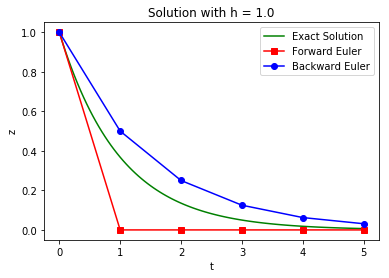

In [4]:
rhs = lambda t, z: -z
sln = lambda t: np.exp(-t)

dt = 1.0
h = create_steps(0.0,5.0,dt)

z0 = [1]

te, Ze = explicit_euler(rhs, h, z0)
ti, Zi = implicit_euler(rhs, h, z0)

plt.figure()

# Use 101 points for exact to make it smooth
texact = np.linspace(0.0,np.sum(h),101)

# Plot solutions
plt.plot(texact, sln(texact),color='green',label="Exact Solution")
plt.plot(te,Ze,color='red',marker='s',label='Forward Euler')
plt.plot(ti,Zi,color='blue',marker='o',label='Backward Euler')
plt.xlabel('t')
plt.ylabel('z')
plt.legend()
plt.title('Solution with h = '+ str(dt))
plt.show()

## 2.5.5 Stability

Keeping $\lambda = 1$, are there any limits on step size?



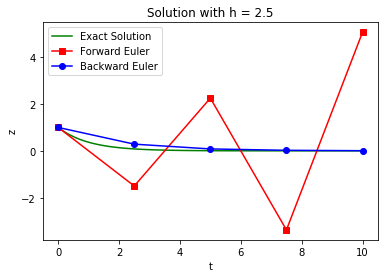

In [5]:
dt = 2.5
h = create_steps(0.0,10.0,dt)

z0 = [1]

te, Ze = explicit_euler(rhs, h, z0)
ti, Zi = implicit_euler(rhs, h, z0)

plt.figure()

# Use 101 points for exact to make it smooth
texact = np.linspace(0.0,np.sum(h),101)

# Plot solutions
plt.plot(texact, sln(texact),color='green',label="Exact Solution")
plt.plot(te,Ze,color='red',marker='s',label='Forward Euler')
plt.plot(ti,Zi,color='blue',marker='o',label='Backward Euler')
plt.xlabel('t')
plt.ylabel('z')
plt.legend()
plt.title('Solution with h = '+ str(dt))
plt.show()

**Key observation:** forward (explicit) Euler becomes unstable with large steps whereas backward (implicit) Euler is stable.

There is a good mathematical reason for this! See http://www.it.uu.se/edu/course/homepage/bridging/ht13/Stability_Analysis.pdf for details.

**Key results** (for this specific test problem):
* Explicit Euler requires step sizes with $h < 2/\lambda$.
* Implicit Euler is *unconditionally stable* provided $\lambda > 0$.
* Similar analysis and concepts extend to Runge-Kutta methods.

## 2.5.6 Error Analysis

How does our choice in step size $h$ impact the error of these numerical techniques?

Excellent tutorial: http://www.math.unl.edu/~gledder1/Math447/EulerError

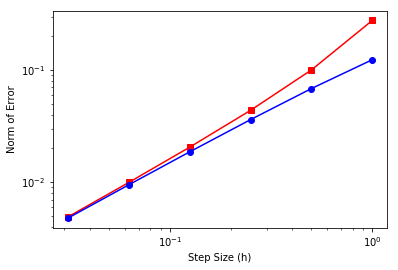

Slope for Forward Euler: 1.0220608473216777
Slope for Backward Euler: 0.9874086317220228


In [10]:
Delta_t = np.array([1.0,.5,.25,.125,.0625,.0625/2])
t_final = 2
error_forward = np.zeros(Delta_t.size)
error_backward = np.zeros(Delta_t.size)

for i in range(0,len(Delta_t)):
    
    # create steps
    h = create_steps(0.0,t_final,Delta_t[i])
    
    # solve
    t,ze = explicit_euler(rhs, h, z0)
    t,zi = implicit_euler(rhs, h, z0)
    zsln = np.exp(-t)
    
    n = len(t) - 1
    
    # Calculate error
    error_forward[i] = np.linalg.norm(ze[:,0] - zsln)/np.sqrt(n)
    error_backward[i] = np.linalg.norm(zi[:,0] - zsln)/np.sqrt(n)
    

plt.loglog(Delta_t,error_forward,'s-',color="red",label="Forward Euler")
plt.loglog(Delta_t,error_backward,'o-',color="blue",label="Backward Euler")

#slope = (np.log(error[-1]) - np.log(error[-2]))/(np.log(Delta_t[-1])- np.log(Delta_t[-2]))
#plt.title("Slope of Error is " + str(slope))
plt.xlabel("Step Size (h)")
plt.ylabel("Norm of Error")
plt.show()

# Calculate slope
calc_slope = lambda error: (np.log(error[-1]) - np.log(error[-2]))/(np.log(Delta_t[-1])- np.log(Delta_t[-2]))

print("Slope for Forward Euler: " + str(calc_slope(error_forward)))
print("Slope for Backward Euler: " + str(calc_slope(error_backward)))

Notice that the error indicates that this is a first-order method in $\Delta t$: when I decrease $\Delta t$ by a factor of 2, the error decreases by a factor of 2.  In this case we measured the error with a slightly different error norm:
$$\mathrm{Error} = \frac{1}{\sqrt{N}}\sqrt{\sum_{n=1}^{N} \left(y^n_\mathrm{approx} - y^n_\mathrm{exact}\right)^2},$$
where $N$ is the number of steps the ODE is solved over.

**Key Results**:
* Implicit and Explicit Euler have $O(h^2)$ local error and $O(h)$ global error.

## 2.5.7 Extensions to DAEs

Consider semi-explicit DAEs:
$$\begin{equation*}
\dot{z} = f(t,z,y), \quad g(z,y) = 0, \quad z(t_0) = z_0
\end{equation*}$$

Runge-Kutta methods are easy to extend.

$$\begin{align*}
z_{i+1} &= z_{i} + h_i \sum_{k=1}^{n_s} b_k f(t_i + c_k h_i, \hat{z}_k, \hat{y}_k) \\
    \hat{z}_k &= z_i + h_i \sum_{j=1}^{n_{rk}} a_{k,j} f(t_i + c_j h_i, \hat{z}_j, \hat{y}_j), \quad k=1,...,n_s \\
    0 &= g(\hat{z}_k, \hat{y}_k), \quad k=1,...,n_s
\end{align*}$$

**Key Results**. If DAE is index 1, then similar stability and order properties as for ODE problems.

**Discussion:** Why are *implicit* RK methods always used for DAE systems?

<!--NAVIGATION-->
< [2.4 Dynamic Optimization: Differential Algebraic Equations (DAEs)](https://ndcbe.github.io/CBE60499/02.04-DAE-modeling.html) | [Contents](toc.html) | [2.5 Quadrature Rules](https://ndcbe.github.io/CBE60499/02.05-Quadrature-Rules.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/02.05-Numeric-Integration.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/02.05-Numeric-Integration.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>